In [2]:
import numpy as np
from pathlib import Path
import cv2
import pandas as pd
from skimage import measure, filters, draw
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tqdm 
from scipy import ndimage

import SimpleITK as sitk
import itkwidgets 
import napari
import copy

from napari.utils.colormaps import colormap_utils as cu
from scipy import stats
import gzip

In [3]:
# Load results of anomaly detection

# np.save(Path("temp/arteries.npy"), arteries)
# np.save(Path("temp/ellipses.npy"), new_ellipses3D)
arteries = np.load(Path("temp/arteries_min_max.npy"))
ellipses3D = np.load(Path("temp/ellipses.npy"))

Récupérer une liste de valeurs de pixels par slice, en prenant en compte uniquement les pixels dans l'ellipse

In [4]:
arteries_only = np.where(ellipses3D == 255, arteries, np.nan)
arteries_only_flatten = arteries_only.reshape(arteries_only.shape[0], arteries_only.shape[1]*arteries_only.shape[2])
list_values=[]
for slice in arteries_only_flatten:
    slice = list(slice[np.logical_not(np.isnan(slice))]) # remove nan
    list_values.append(slice)

In [5]:
# a modifier pour avoir une classe calcification avec la slice, le pourcentage et le masque de calcification

def find_calcifications (pixel_values, pourcentage):
    ''' 
    Fonction pour trouver les calcifications les plus importantes de chaque masque
    Args:
        pixel_values (list[list[double]]) : valeurs des pixels dans chacune des coupes de l'image
        pourcentage (int) : le pourcentage de calcifications qu'on veut retourner 
    Return:
        list_calcifications (list[int, double]) : retourne un tuple avec l'index de la coupe et son pourcentage de calcification
    '''
    # calcul pourcentage de calcification
    proportion_calcification = []
    for slice in pixel_values:
        nb_pixel_250 = sum(1 for valeur in slice if valeur > 250)
        proportion = nb_pixel_250 / len(slice)
        proportion_calcification.append(proportion)

    # sélectionner les n plus grosses calcifications
    n = int(pourcentage/100 * len(list_values))
    sorted_indices = np.argsort(proportion_calcification)[::-1] #trier indices par ordre décroissant
    top_n_indices = sorted_indices[:n]
    list_calcifications = [(i, proportion_calcification[i]) for i in top_n_indices]

    return list_calcifications

In [6]:
def remove_calcifications(pixel_values):
    for i in range(len(pixel_values)):
        pixel_values[i] = [valeur for valeur in list_values[i] if valeur < 250]

In [7]:
def find_occlusions(pixel_values):
    ''' 
    Fonction qui permet de trouver les coupes contenant des occlusions grâce à la comparaison de la distribution des valeurs
    des pixels de la coupe avec une distribution de référence.  Cette fonction utilise le test de Kolmogorov-Smirnov qui permet
    de comparer la distribution empirique cumulative de deux échantillons pour tester s'ils suivent la même loi ou non.
    
    Args:
        pixel_values (list[list[double]]) : valeurs des pixels dans chacune des coupes de l'image
    Return:
        list_occlusions (list[int, double]) : retourne un tuple avec l'index de la coupe et la valeur du résultat du test.
        Plus la valeur du test est élevée plus la différence de la coupe avec la référence est importante
    '''
    # mettre toutes les valeurs de pixels de l'image dans une seule liste
    list_values_flatten = [element for sublist in pixel_values for element in sublist]

    list_pvalues = []
    list_stats_test = []
    list_mean = []

    for slice in pixel_values:
        a = stats.ks_2samp(slice, list_values_flatten)
        list_stats_test.append(a[0])
        list_pvalues.append(a[1])
        list_mean.append(np.mean(slice))

    # sélectionner les 20 plus grosses occlusions (valeurs moyenne < moyenne)
    sorted_indices = np.argsort(list_stats_test)[::-1] #trier indices par ordre décroissant
    count = 0
    list_occlusions = []
    for index in sorted_indices:
        if list_mean[index] < np.mean(list_mean): # prendre seulement  les coupes trop foncées et pas les coupes trop claires
            list_occlusions.append((index, list_stats_test[index]))
            count += 1
            if count > 20:
                break

    return list_occlusions

In [8]:
print(find_calcifications(list_values, 5))

[(71, 0.2643171806167401), (72, 0.24675324675324675), (73, 0.2412280701754386), (70, 0.24034334763948498), (69, 0.23555555555555555), (67, 0.22317596566523606), (68, 0.20851063829787234), (66, 0.20306513409961685), (74, 0.19736842105263158), (75, 0.16176470588235295), (80, 0.15196078431372548), (144, 0.1488673139158576), (76, 0.14761904761904762), (145, 0.1465798045602606), (65, 0.1417624521072797), (146, 0.14012738853503184), (77, 0.1391304347826087), (82, 0.13736263736263737), (150, 0.13119533527696792), (149, 0.13099041533546327)]


In [9]:
remove_calcifications(list_values)

In [10]:
list_occlusions = find_occlusions(list_values)

In [11]:
print(list_occlusions)

[(3, 0.6615179331256764), (0, 0.6552835240738539), (20, 0.6242967315220337), (21, 0.6141542069198163), (4, 0.5248024184405171), (22, 0.48646356071603736), (18, 0.43266305028524554), (5, 0.4242729177578249), (15, 0.4236723317883001), (19, 0.3754491199369868), (121, 0.3610907828826657), (14, 0.3494998135133538), (17, 0.34284896732709264), (122, 0.3400423073022245), (120, 0.3389271964036159), (16, 0.3328219003979587), (123, 0.32271022503504554), (23, 0.3172330411265247), (1, 0.3168688259845217), (124, 0.31205490738756714), (114, 0.3037945282685858)]


In [ ]:
# ## en cours de test
# # creer un joli numpy array à partir de ma liste
# npa_occlusions = np.array(list_occlusions)
# print(npa_occlusions)

# # essayer de regrouper si plusieurs occlusions à côté
# for occlusion in list_occlusions:
#     val = occlusion[0]+1 
#     if val in list_occlusions[0]:
#         print(occlusion[0])

In [ ]:
viewer = napari.Viewer()
image_layer = viewer.add_image(arteries, colormap="gray", contrast_limits=(0,255))
image_layer = viewer.add_image(ellipses3D, colormap="blue", contrast_limits=(0,255), blending="additive")
napari.run()

jolis histogrammes pour tester des trucs

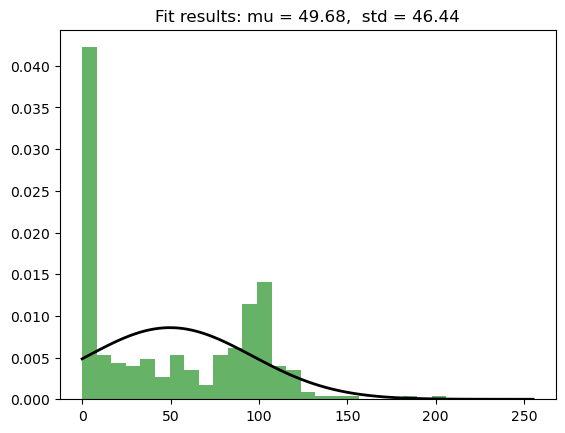

In [12]:
# fit a normal distribution on the points on each slice
from scipy.stats import norm

my_slice = list_values[120]

# fit a normal distribution
mu, std = norm.fit(my_slice)
plt.hist(my_slice, bins=25, density=True, alpha=0.6, color='g')

# Plot
xmin = 0
xmax = 255
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

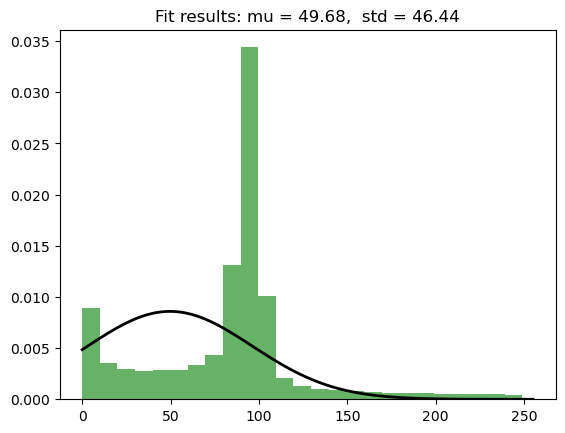

In [13]:
# créer une distribution de référence : en utilisant tous les points ?

# fit a normal distribution
list_values_flatten = [element for sublist in list_values for element in sublist]
mu0, std0 = norm.fit(list_values_flatten)
plt.hist(list_values_flatten, bins=25, density=True, alpha=0.6, color='g')

# Plot
xmin = 0
xmax = 255
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()